In [8]:
import torch
import numpy as np
import pyro
import pyro.distributions as dist
from pyro.infer import NUTS,MCMC

import matplotlib.pyplot as plt

In [9]:
torch.manual_seed(42)

mu_true = torch.tensor([25.0,60.0,1013.0, 0.02])  # Temparature, Humidity, Pressure, Vibration
sigma_true = torch.tensor([2.0,5.0,8.0,0.01])
cov_true = torch.diag(sigma_true ** 2)

n = 100

x = dist.MultivariateNormal(mu_true, covariance_matrix= cov_true).sample((n,))

In [10]:
def model(data):
    # Prior mu
    mu = pyro.sample("mu", dist.MultivariateNormal(torch.zeros(4), 100 * torch.eye(4)))

    # Prior sigma
    scale = pyro.sample("scale", dist.LogNormal(torch.zeros(4), torch.ones(4)))
    corr = torch.eye(4)

    L = torch.diag(scale) @ corr
    sigma = L @ L.T

    with pyro.plate("data", data.shape[0]):
        pyro.sample("obs", dist.MultivariateNormal(mu, covariance_matrix=sigma), obs = data)

In [11]:
nuts_kernel = NUTS(model)
mcmc = MCMC(nuts_kernel, num_samples=10000,warmup_steps=2000,num_chains=1)
mcmc.run(x)

Sample: 100%|██████████| 12000/12000 [03:37, 55.24it/s, step size=3.81e-01, acc. prob=0.934]



In [12]:
posterior_samples = mcmc.get_samples()
mu_samples = posterior_samples["mu"]
scale_samples = posterior_samples["scale"]

# Reconstructed covariance matrix
cov_samples = torch.matmul(torch.diag_embed(scale_samples),
                           (torch.diag_embed(scale_samples)).transpose(-1, -2))

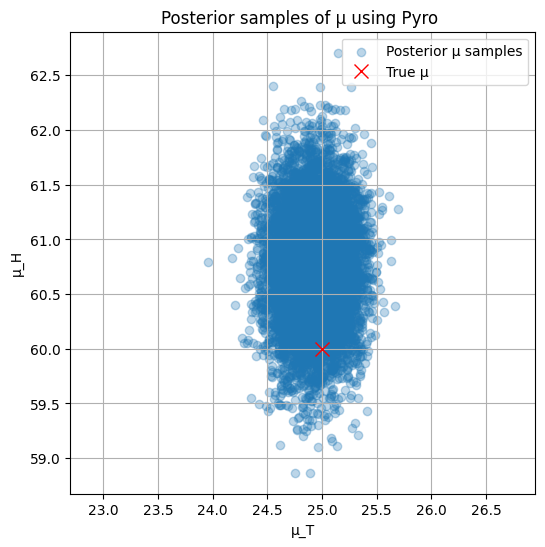

In [13]:
mu_samples_np = mu_samples.detach().numpy()

plt.figure(figsize = (6,6))
plt.scatter(mu_samples_np[:,0], mu_samples_np[:,1], alpha = 0.3, label = "Posterior μ samples")
plt.plot(mu_true[0], mu_true[1], "rx", markersize = 10, label = "True μ" )
plt.xlabel("μ_T")
plt.ylabel("μ_H")
plt.title("Posterior samples of μ using Pyro ")
plt.grid(True)
plt.legend()
plt.axis("Equal")
plt.show()